## Model Fit in Linear Regression - Lab

## Introduction
In this lab, you'll learn how to evaluate your model results, and you'll learn methods to select the appropriate features using stepwise selection.

## Objectives
You will be able to:
* Analyze the results of regression and R-squared and adjusted-R-squared 
* Understand and apply forward and backward predictor selection

## The Boston Housing Data once more

We pre-processed the Boston Housing Data the same way we did before:

- We dropped "ZN" and "NOX" completely
- We categorized "RAD" in 3 bins and "TAX" in 4 bins
- We used min-max-scaling on "B", "CRIM" and "DIS" (and logtransformed all of them first, except "B")
- We used standardization on "AGE", "INDUS", "LSTAT" and "PTRATIO" (and logtransformed all of them first, except for "AGE") 

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_features = boston_features.drop(["NOX","ZN"],axis=1)

# first, create bins for based on the values observed. 3 values will result in 2 bins
bins = [0,6,  24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for based on the values observed. 4 values will result in 3 bins
bins = [0, 270, 360, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix="TAX")
rad_dummy = pd.get_dummies(bins_rad, prefix="RAD")
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)

age = boston_features["AGE"]
b = boston_features["B"]
logcrim = np.log(boston_features["CRIM"])
logdis = np.log(boston_features["DIS"])
logindus = np.log(boston_features["INDUS"])
loglstat = np.log(boston_features["LSTAT"])
logptratio = np.log(boston_features["PTRATIO"])

# minmax scaling
boston_features["B"] = (b-min(b))/(max(b)-min(b))
boston_features["CRIM"] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features["DIS"] = (logdis-min(logdis))/(max(logdis)-min(logdis))

#standardization
boston_features["AGE"] = (age-np.mean(age))/np.sqrt(np.var(age))
boston_features["INDUS"] = (logindus-np.mean(logindus))/np.sqrt(np.var(logindus))
boston_features["LSTAT"] = (loglstat-np.mean(loglstat))/np.sqrt(np.var(loglstat))
boston_features["PTRATIO"] = (logptratio-np.mean(logptratio))/(np.sqrt(np.var(logptratio)))

## Perform stepwise selection

The code for stepwise selection is copied below.

In [2]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [3]:
results = stepwise_selection(boston_features,boston['target'])

Add  LSTAT                          with p-value 9.27989e-122
Add  RM                             with p-value 1.98621e-16
Add  PTRATIO                        with p-value 2.5977e-12
Add  DIS                            with p-value 2.85496e-09
Add  B                              with p-value 2.77572e-06
Add  TAX_(0, 270]                   with p-value 0.000855799
Add  CHAS                           with p-value 0.00151282
Add  INDUS                          with p-value 0.00588575


### Build the final model again in Statsmodels

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [19]:
stepwise_data = boston_features[results]
stepwise_data['TAX'] = stepwise_data['TAX_(0, 270]']
stepwise_data.drop('TAX_(0, 270]', axis = 1,inplace=True)
stepwise_data.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,LSTAT,RM,PTRATIO,DIS,B,CHAS,INDUS,TAX
0,-1.275260,6.575,-1.443977,0.542096,1.000000,0.0,-1.704344,0
1,-0.263711,6.421,-0.230278,0.623954,1.000000,0.0,-0.263239,1
2,-1.627858,7.185,-0.230278,0.623954,0.989737,0.0,-0.263239,1
3,-2.153192,6.998,0.165279,0.707895,0.994276,0.0,-1.778965,1
4,-1.162114,7.147,0.165279,0.707895,1.000000,0.0,-1.778965,1


In [22]:
target = pd.DataFrame([])
target['MEDV'] = boston['target']
boston_df = pd.concat([stepwise_data, target], axis = 1)

In [25]:
outcome = 'MEDV'
pred_sum = '+'.join(stepwise_data.columns)
formula = outcome + '~' + pred_sum

model = ols(formula = formula, data = boston_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     215.7
Date:                Wed, 26 Dec 2018   Prob (F-statistic):          2.69e-156
Time:                        15:02:59   Log-Likelihood:                -1461.3
No. Observations:                 506   AIC:                             2941.
Df Residuals:                     497   BIC:                             2979.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8980      2.813      1.742      0.082      -0.628      10.424
LSTAT         -5.5932      0.319    -17.538      0.000      -6.220      -4.967
RM             2.8294      0.386      7.333      0.000       2.071       3.587
PTRATIO       -1.3265      0.226     -5.878      0.000      -1.770      -0.883
DIS           -9.1984      1.333     -6.898      0.000     -11.818      -6.579
B              3.9052      0.931      4.195      0.000       2.076       5.734
CHAS           2.7988      0.791      3.539      0.000       1.245       4.353
INDUS         -0.9574      0.346     -2.766      0.006      -1.637      -0.277
TAX            1.4418      0.552      2.614      0.009       0.358       2.526
==============================================================================
Omnibus:                      114.307   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.579
Skew:                           0.945   Prob(JB):                    1.62e-105
Kurtosis:                       7.395   Cond. No.                         96.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Where our stepwise procedure mentions that "CHAS" was added with a p-value of 0.00151282, but our statsmodels output returns a p-value of 0.000. What is the intuition behind this?

It has a p-value of 0.0015 as it's being added to the model, without INDUS and TAX added to the model. When the other features are added it modifies its p-value.

## Use Feature ranking with recursive feature elimination

Use feature ranking to select the 5 most important features

In [26]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 5)
selector = selector.fit(boston_features, boston_df["MEDV"])

In [53]:
boston_features.columns*selector.support_

TypeError: cannot perform __mul__ with this index type: Index

Fit the linear regression model again using the 5 columns selected

In [29]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ 2.93498961  3.43718997 -6.58036332  4.65357304 -6.25217488]
-0.49739821537889384


Now, predict $\hat y$ using your model. you can use `.predict()` in scikit-learn

In [57]:
y_hat = selector.predict(boston_features)

Now, using the formulas of R-squared and adjusted-R-squared below, and your Python/numpy knowledge, compute them and contrast them with the R-squared and adjusted-R-squared in your statsmodels output using stepwise selection. Which of the two models would you prefer?

$SS_{residual} = \sum (y - \hat{y})^2 $

$SS_{total} = \sum (y - \bar{y})^2 $

$R^2 = 1- \dfrac{SS_{residual}}{SS_{total}}$

$R^2_{adj}= 1-(1-R^2)\dfrac{n-1}{n-p-1}$

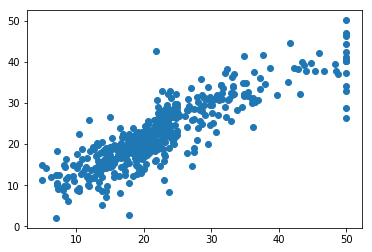

In [59]:
import matplotlib.pyplot as plt
plt.scatter(target['MEDV'],y_hat)

In [61]:
y = np.array(target['MEDV'])

In [62]:
SSres = np.sum((y-y_hat)**2)
SSres

10978.90917178611

In [63]:
SStot = np.sum((y-np.mean(y))**2)
SStot

42716.29541501977

In [64]:
R2 = 1-SSres/SStot
R2

0.7429807743129864

## Level up - Optional

- Perform variable selection using forward selection, using this resource: https://planspace.org/20150423-forward_selection_with_statsmodels/. Note that this time features are added based on the adjusted-R-squared!
- Tweak the code in the `stepwise_selection()`-function written above to just perform forward selection based on the p-value.

## Summary
Great! You now performed your own feature selection methods!